In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# snnTorch imports
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import snntorch.spikegen as spikegen
import os
from torch.nn.utils.parametrizations import weight_norm
# ======================
# Dataset Class
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class EMGDataset(Dataset):
    """EMG 데이터셋 클래스"""
    def __init__(self, X, y, transform=None):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample, label

# ======================
# TCN Components
# ======================

class TemporalBlock(nn.Module):
    """TCN의 기본 빌딩 블록"""
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(n_outputs)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(n_outputs)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        # Residual connection
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)

        if out.shape != residual.shape:
            min_len = min(out.shape[2], residual.shape[2])
            out = out[:, :, :min_len]
            residual = residual[:, :, :min_len] 
            
        out += residual
        return self.relu(out)

class TemporalConvNet(nn.Module):
    """Temporal Convolutional Network"""
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            
            # Causal padding
            padding = (kernel_size - 1) * dilation_size
            
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, 
                                   stride=1, dilation=dilation_size, 
                                   padding=padding, dropout=dropout)]
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, features) -> (batch_size, features, seq_len)
        x = x.transpose(1, 2)
        out = self.network(x)
        # Back to (batch_size, seq_len, features)
        return out.transpose(1, 2)

# ======================
# SNN Components using snnTorch
# ======================

class SpikeEncoder(nn.Module):
    """연속 신호를 스파이크로 변환하는 인코더"""
    def __init__(self, encoding_type='rate', num_steps=10):
        super(SpikeEncoder, self).__init__()
        self.encoding_type = encoding_type
        self.num_steps = num_steps
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, features)
        batch_size, seq_len, features = x.shape
        if self.encoding_type == 'delta':
            # 1) (B,T,C) 그대로 delta에 투입
            #    snntorch.spikegen.delta는 (B,T,C) -> (B,T,C) 형태 반환(버전에 따라 다를 수 있으니 아래 체크 권장)
            spikes = spikegen.delta(x, threshold=0.1)   # (B,T,C)

            # 2) 시간 차원 첫 번째로: (T,B,C)
            spikes = spikes.transpose(0, 1).contiguous()

            return spikes  # (T, B, C)
        if self.encoding_type == 'rate':
            # Rate encoding: 입력 크기에 비례하는 스파이크 확률
            # 입력을 0-1 범위로 정규화
            p = torch.sigmoid((x - 0.5) / 2.0)  # (B,T,C)
            p = p * 0.05   
                                             # 전체 스케일 다운
            spikes = spikegen.rate(p, num_steps=self.num_steps)   # (num_steps, B, T, C)
            return spikes
        
        elif self.encoding_type == 'latency':
            # Latency encoding
            spikes = spikegen.latency(x, num_steps=seq_len, normalize=True, linear=True)
            return spikes
        
        else:  # 'delta'
            # Delta modulation
            spikes = spikegen.delta(x, threshold=0.1)   # (B,T,C)

            # 2) 시간 차원 첫 번째로: (T,B,C)
            spikes = spikes.transpose(0, 1).contiguous()

            return spikes  # (T, B, C)

class SNNBlock(nn.Module):
    """SNN 블록 (LIF 뉴런 사용)"""
    def __init__(self, input_size, hidden_size, num_steps=10, beta=0.9, threshold=1.0):
        super(SNNBlock, self).__init__()
        
        self.num_steps = num_steps
        self.hidden_size = hidden_size
        
        # Linear layer
        self.fc = nn.Linear(input_size, hidden_size)
        
        # LIF neuron
        self.lif = snn.Leaky(beta=beta, threshold=threshold, 
                            spike_grad=surrogate.fast_sigmoid())
        
    def forward(self, x):                    # x: (T,B,input_size)
        T, B, _ = x.shape                    # ❗ self.num_steps 대신 T 사용
        mem = self.lif.init_leaky()
        spk_rec, mem_rec = [], []
        for t in range(T):
            cur = self.fc(x[t])              # (B,H)
            spk, mem = self.lif(cur, mem)
            spk_rec.append(spk); mem_rec.append(mem)
        return torch.stack(spk_rec, 0), torch.stack(mem_rec, 0)

class SpikingNeuralNetwork(nn.Module):
    """Multi-layer SNN"""
    def __init__(self, input_size, hidden_sizes, num_steps=10, beta=0.9, threshold=1.0, encoding_type='rate'):
        super(SpikingNeuralNetwork, self).__init__()
        
        self.num_steps = num_steps
        self.layers = nn.ModuleList()
        
        # Input encoding
        self.encoder = SpikeEncoder(encoding_type=encoding_type, num_steps=num_steps)
        
        # SNN layers
        layer_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)):
            self.layers.append(
                SNNBlock(layer_sizes[i], layer_sizes[i+1], 
                        num_steps=num_steps, beta=beta, threshold=threshold)
            )
    
    def forward(self, x):
        B, T, F = x.shape
        # num_steps 고정 사용
        num_steps = self.num_steps

        spikes = self.encoder(x)  # (num_steps, B, T_seq, C)  # latency 기준
        spikes = spikes.mean(dim=2).contiguous()  # (num_steps, B, C)

        for layer in self.layers:
            spikes, _ = layer(spikes)  # (num_steps, B, H)
        return spikes




# ======================
# Model Architectures
# ======================
class Chomp1d(nn.Module):
    """
    Remove extra padding from the right side
    """
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous() if self.chomp_size > 0 else x

spike_grad = surrogate.fast_sigmoid(slope=25)

class SpikingTemporalBlock(nn.Module):
    """Spiking 버전 Temporal Block (막전위 유지)"""
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2,
                 beta=0.9, v_th=1.0):
        super().__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.lif1  = snn.Leaky(beta=beta, threshold=v_th, spike_grad=spike_grad, init_hidden=False)
        self.do1   = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.lif2  = snn.Leaky(beta=beta, threshold=v_th, spike_grad=spike_grad, init_hidden=False)
        self.do2   = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None

    def forward(self, x, mem1, mem2, return_spk=False):
        x1 = self.chomp1(self.conv1(x))
        spk1, mem1 = self.lif1(x1, mem1)
        x1 = self.do1(spk1)

        x2 = self.chomp2(self.conv2(x1))
        spk2, mem2 = self.lif2(x2, mem2)
        out = self.do2(spk2)

        res = x if self.downsample is None else self.downsample(x)
        y = out + res

        if return_spk:
            # spk2: (B, C, T_seq) — 마지막 LIF의 바이너리 스파이크
            return y, mem1, mem2, spk2
        else:
            return y, mem1, mem2



# ======================
# Spiking Temporal ConvNet
# ======================
class SpikingTCN(nn.Module):
    """에너지 효율적인 Spiking-TCN (막전위 유지)"""
    def __init__(self, num_inputs, num_channels, num_classes,
                 kernel_size=2, dropout=0.2, timesteps=10, beta=0.9, v_th=1.0):
        super().__init__()
        self.timesteps = timesteps
        self.encoder = SpikeEncoder(encoding_type='rate', num_steps=timesteps)

        self.blocks = nn.ModuleList()
        for i in range(len(num_channels)):
            dilation = 2 ** i
            in_c  = num_inputs if i == 0 else num_channels[i-1]
            out_c = num_channels[i]
            pad   = (kernel_size - 1) * dilation
            self.blocks.append(
                SpikingTemporalBlock(in_c, out_c, kernel_size, 1, dilation, pad,
                              dropout=dropout, beta=beta, v_th=v_th)
            )

        self.classifier = nn.Linear(num_channels[-1], num_classes)

    @torch.no_grad()
    def collect_spike_stats(self, spike_buffers, T_total):
        """타임스텝 동안 누적된 스파이크로 간단 통계 산출"""
        stats = {}
        for bidx, buf in spike_buffers.items():
            stats[f'block{bidx}_lif1_rate_per_ch'] = (buf['lif1_sum'] / T_total)  # (C,)
            stats[f'block{bidx}_lif2_rate_per_ch'] = (buf['lif2_sum'] / T_total)  # (C,)
            stats[f'block{bidx}_lif1_total'] = buf['lif1_sum'].sum().item()
            stats[f'block{bidx}_lif2_total'] = buf['lif2_sum'].sum().item()
        return stats

    def forward(self, x, return_spikes=False):
        spikes = self.encoder(x)  # (T, B, F_in)
        mem_states = [(blk.lif1.init_leaky(), blk.lif2.init_leaky()) for blk in self.blocks]

        logits_sum = 0.0
        spk_tbC_list = []  # 여기 모아 T×B×C_last 로 반환

        for t in range(self.timesteps):
            cur = spikes[t]                  # (B, T_seq, C_in)
            cur = cur.transpose(1, 2).contiguous()  # (B, C_in, T_seq)

            for i, blk in enumerate(self.blocks):
                last_block = (i == len(self.blocks) - 1) and return_spikes
                if last_block:
                    cur, m1, m2, spk2 = blk(cur, *mem_states[i], return_spk=True)  # spk2: (B,C_last,T_seq)
                else:
                    cur, m1, m2 = blk(cur, *mem_states[i])
                mem_states[i] = (m1, m2)

            # 분류용 풀링
            pooled = cur.mean(dim=2)
            logits_sum += self.classifier(pooled)

            # 비교용 스파이크 시퀀스: (T,B,C_last)
            if return_spikes:
                # 래스터/히스토그램 비교를 위해 conv 시간축을 이진 합성:
                # conv 시간축 중 "한 번이라도 쏘면 1" 로 축약  => (B, C_last)
                spk_frame = (spk2 > 0).amax(dim=2).float()
                spk_tbC_list.append(spk_frame)

        logits = logits_sum / self.timesteps

        if return_spikes:
            spk_tbC = torch.stack(spk_tbC_list, dim=0)  # (T, B, C_last)
            # 원래 통계들에 같이 넣어서 보낼 수도 있고,
            # 최소한 spk_tbC만 넘겨도 시각화는 동일 루틴 재사용 가능
            stats = {"spk_tbC": spk_tbC}
            return logits, stats

        return logits

class TCNClassifier(nn.Module):
    """TCN 기반 EMG 분류기"""
    def __init__(self, input_size, num_classes, tcn_channels=[64, 128, 256], 
                 kernel_size=3, dropout=0.2):
        super(TCNClassifier, self).__init__()
        
        self.tcn = TemporalConvNet(input_size, tcn_channels, kernel_size, dropout)
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(tcn_channels[-1], num_heads=8, batch_first=True)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(tcn_channels[-1], 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        # TCN feature extraction
        tcn_out = self.tcn(x)  # (batch_size, seq_len, features)
        
        # Self-attention
        attn_out, _ = self.attention(tcn_out, tcn_out, tcn_out)
        
        # Global average pooling
        pooled = torch.mean(attn_out, dim=1)  # (batch_size, features)
        
        # Classification
        output = self.classifier(pooled)
        return output

class SNNClassifier(nn.Module):
    """SNN 기반 EMG 분류기"""
    def __init__(self, input_size, num_classes, hidden_sizes=[256, 128, 64], 
                 num_steps=10, beta=0.9, threshold=1.0, encoding_type='rate'):
        super(SNNClassifier, self).__init__()
        
        self.num_steps = num_steps
        self.snn = SpikingNeuralNetwork(input_size, hidden_sizes, 
                                       num_steps, beta, threshold, encoding_type)
        
        # Output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)
        
    def forward(self, x):
        batch_size, seq_len, features = x.shape
        
        # Get spike outputs from SNN
        spikes = self.snn(x)  # (num_steps, batch_size, hidden_size)

        spike_rates = spikes.mean(dim=0) # (B, H)  <-- 시간축 평균

        output = self.output_layer(spike_rates)
        
        return output



# ======================
# Data Loading Functions
# ======================

def load_ninapro_data(file_path):
    """NinaPro 데이터를 로드하고 전처리하는 함수"""
    try:
        # .mat 파일 로드
        data = sio.loadmat(file_path)
        
        print("Available keys in the data:", list(data.keys()))
        
        # EMG 데이터 추출
        if 'emg' in data:
            emg_data = data['emg']
        elif 'data' in data:
            emg_data = data['data']
        else:
            data_keys = [k for k in data.keys() if not k.startswith('__')]
            emg_data = data[data_keys[0]]
        
        # 라벨 데이터 추출
        if 'stimulus' in data:
            labels = data['stimulus'].flatten()
        elif 'restimulus' in data:
            labels = data['restimulus'].flatten()
        elif 'glove' in data:
            labels = data['glove']
            if labels.ndim > 1:
                labels = labels[:, 0]
        else:
            label_keys = [k for k in data.keys() if 'stimulus' in k.lower() or 'label' in k.lower()]
            if label_keys:
                labels = data[label_keys[0]].flatten()
            else:
                data_keys = [k for k in data.keys() if not k.startswith('__')]
                labels = data[data_keys[1]].flatten() if len(data_keys) > 1 else np.zeros(emg_data.shape[0])
        
        print(f"EMG data shape: {emg_data.shape}")
        print(f"Labels shape: {labels.shape}")
        print(f"Unique labels: {np.unique(labels)}")
        
        return emg_data, labels
    
    except Exception as e:
        print(f"Error loading data: {e}")
        print("Generating sample data for demonstration...")
        
        # 샘플 데이터 생성
        n_samples = 10000
        n_channels = 12
        emg_data = np.random.randn(n_samples, n_channels) * 0.1
        
        # EMG 신호처럼 보이도록 시간적 상관관계 추가
        for i in range(n_channels):
            emg_data[:, i] += np.sin(np.linspace(0, 100*np.pi, n_samples) + i) * 0.05
            emg_data[:, i] += np.convolve(np.random.randn(n_samples), 
                                        np.ones(5)/5, mode='same') * 0.02
        
        labels = np.random.randint(0, 7, n_samples)  # 0-6 클래스
        return emg_data, labels

def preprocess_data_for_networks(emg_data, labels, window_size=200, overlap=100):
    """네트워크를 위한 EMG 데이터 전처리"""
    # 레이블이 0인 rest 구간 제거 (선택사항)
    non_zero_mask = labels != 0
    emg_data = emg_data[non_zero_mask]
    labels = labels[non_zero_mask]
    
    # 윈도우 기반 시퀀스 생성
    windowed_sequences = []
    windowed_labels = []
    
    step_size = window_size - overlap
    
    for i in range(0, len(emg_data) - window_size + 1, step_size):
        window = emg_data[i:i+window_size]
        window_label = labels[i:i+window_size]
        
        # 윈도우 내에서 가장 빈번한 라벨 사용
        unique_labels, counts = np.unique(window_label, return_counts=True)
        dominant_label = unique_labels[np.argmax(counts)]
        
        windowed_sequences.append(window)
        windowed_labels.append(dominant_label)
    
    return np.array(windowed_sequences), np.array(windowed_labels)

# ======================
# Training Functions
# ======================

def train_model(model, train_loader, val_loader, num_epochs=2, lr=0.001):
    """모델 훈련 함수"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_acc = 0.0
    patience_counter = 0
    patience = 20
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        train_acc = 100 * train_correct / train_total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        
        # Learning rate scheduling
        scheduler.step(val_acc)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), './output/rate/best_model_rate.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%')
    
    # Load best model
    model.load_state_dict(torch.load('./output/rate/best_model_rate.pth'))
    
    history = {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'val_loss': val_losses,
        'val_acc': val_accuracies
    }
    
    return model, history

def evaluate_model(model, test_loader):
    """모델 평가 함수"""
    model.eval()
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    test_acc = 100 * test_correct / test_total
    return test_acc, np.array(all_predictions), np.array(all_targets)

# ======================
# Visualization Functions
# ======================

def plot_training_history(histories, model_names):
    """훈련 과정 시각화"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for i, (history, name) in enumerate(zip(histories, model_names)):
        color = colors[i % len(colors)]
        
        # Training accuracy
        axes[0, 0].plot(history['train_acc'], label=f'{name}', 
                       color=color, linewidth=2)
        
        # Validation accuracy
        axes[0, 1].plot(history['val_acc'], label=f'{name}', 
                       color=color, linewidth=2)
        
        # Training loss
        axes[1, 0].plot(history['train_loss'], label=f'{name}', 
                       color=color, linewidth=2)
        
        # Validation loss
        axes[1, 1].plot(history['val_loss'], label=f'{name}', 
                       color=color, linewidth=2)
    
    axes[0, 0].set_title('Training Accuracy', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_title('Validation Accuracy', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_title('Training Loss', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_title('Validation Loss', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Model Training Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    count_path = os.path.join("./output/rate", "model_trainint_rate4.png")
    plt.savefig(count_path)
    plt.close(fig)

def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    """혼동 행렬 시각화"""
    cm = confusion_matrix(y_true, y_pred)
    
    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    count_path = os.path.join("./output/rate", "rasterplot_rate4.png")
    plt.savefig(count_path)
    plt.close(fig)

def visualize_snn_spikes_new(model, sample_data, num_steps=10, num_neurons=100):
    """SNN 스파이크 시각화"""
    # if not hasattr(model, 'snn'):
    #     print("Model doesn't have SNN component")
    #     return
    
    model.eval()
    with torch.no_grad():
        sample_data = sample_data.to(device)
        x = sample_data[:1]
        
        # 하이브리드: TCN→Encoder→SNNCore 경로로 스파이크 생성
        if hasattr(model, 'tcn') and hasattr(model, 'encoder'):
            tcn_out = model.tcn(x)                 # (1, T, F_tcn)
            spikes = model.encoder(tcn_out)        # (T, 1, F_tcn)
            spk = model.snn(spikes)                # (T, 1, H)
        else:
            # 구형 모델 호환
            spk = model.snn(x)                     # (T, 1, H)
        
        # spikes shape: (num_steps, 1, hidden_size)
        spike_data = spk.squeeze(1).cpu().numpy()  # (num_steps, hidden_size)
        
        arr = np.asarray(spike_data)
        if arr.ndim == 3:        # (B, T, N)
            firing_rates = arr.mean(axis=(0,1))   # -> (N,)
        elif arr.ndim == 2:      # (T, N)
            firing_rates = arr.mean(axis=0)       # -> (N,)
        else:
            raise ValueError(f"Unexpected spike_data shape: {arr.shape}")

        fig = plt.figure(figsize=(15, 8))
        
        # Raster plot
        for neuron_idx in range(min(num_neurons, spike_data.shape[1])):
            spike_times = np.where(spike_data[:, neuron_idx] > 0.5)[0]
            plt.scatter(spike_times, [neuron_idx] * len(spike_times), 
                       marker='|', s=250, alpha=0.9, linewidths=2, color='black')
        
        plt.xlabel('Time Steps')
        plt.ylabel('Neuron Index')
        plt.title('SNN Spike Raster Plot')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        count_path = os.path.join("./output/rate", "snn_rate_raster4.png")
        plt.savefig(count_path)
        plt.close(fig)
      
        
        # Firing rate histogram
        fig = plt.figure(figsize=(12, 5))
        plt.bar(range(len(firing_rates)), firing_rates, alpha=0.7)
        plt.xlabel('Neuron Index')
        plt.ylabel('Firing Rate')
        plt.title('Neuron Firing Rates')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        count_path = os.path.join("./output/rate", "neuron_firing_rate4.png")
        plt.savefig(count_path)
        plt.close(fig)

def plot_model_comparison_results(results):
    """모델 성능 비교 결과 시각화"""
    model_names = list(results.keys())
    accuracies = [results[name]['test_acc'] for name in model_names]
    
    fig = plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, accuracies, alpha=0.7, 
                   color=['blue', 'red', 'green', 'orange'])
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.ylabel('Test Accuracy (%)')
    plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    count_path = os.path.join("./output/rate", "model_performance_com_rate4.png")
    plt.savefig(count_path)
    plt.close(fig)

def visualize_snn_spikes(model, x, title_prefix="Model"):
    model.eval()
    with torch.no_grad():
        # 공통: (T, B, N) 형태의 spike 시퀀스를 확보
        if isinstance(model, SpikingTCN):
            logits, stats = model(x, return_spikes=True)
            spk = stats["spk_tbC"]  # (T, B, C_last)
        elif isinstance(model, SNNClassifier):
            spk = model.snn(x)      # (T, B, H)
        else:
            raise TypeError("SpikingTCN 또는 SNNClassifier만 지원")

        T, B, N = spk.shape
        # 발화율/카운트
        counts_per_neuron = spk.sum(dim=(0,1))        # (N,)
        rate_per_neuron   = counts_per_neuron / T     # 배치 평균된 타임스텝당 발화율
        total_spikes      = counts_per_neuron.sum().item()

        print(f"=== {title_prefix} Spike Stats ===")
        print(f"T={T}, B={B}, N={N}")
        print(f"Total spikes: {total_spikes:.0f}")
        print(f"Mean firing rate per neuron: {rate_per_neuron.mean():.4f}")
        print(f"Max firing rate per neuron:  {rate_per_neuron.max():.4f}")

        os.makedirs("./output/rate", exist_ok=True)

        # 히스토그램 (두 모델 동일)
        fig = plt.figure()
        plt.hist(rate_per_neuron.cpu().numpy(), bins=40)
        plt.title(f"{title_prefix} Neuron Firing Rate Distribution")
        plt.xlabel("Firing rate (spikes / timestep)")
        plt.ylabel("Neuron count")
        plt.savefig(os.path.join("./output/rate", f"{title_prefix}_rate_hist.png"))
        plt.close(fig)

        # 래스터 (두 모델 동일)
        fig = plt.figure(figsize=(10, 5))
        spk_cpu = spk.cpu()
        max_neurons = min(N, 100)
        for h in range(max_neurons):
            # (T, B)에서 nonzero: [t, b]
            nz = (spk_cpu[:, :, h] > 0).nonzero(as_tuple=False)
            if nz.numel() == 0:
                continue
            # 배치 인덱스를 살짝 오프셋으로 그려 겹침 방지
            plt.scatter(nz[:,0], h + nz[:,1]*0.1, 
                marker='|', s=250, alpha=0.9, linewidths=2, color='black')
        plt.title(f"{title_prefix} Raster (first {max_neurons} neurons)")
        plt.xlabel("Time step")
        plt.ylabel("Neuron index")
        plt.savefig(os.path.join("./output/rate", f"{title_prefix}_raster.png"))
        plt.close(fig)

# ======================
# Main Function
# ======================


    # 데이터 경로 설정
DATA_PATH = "../../data/DB6/DB6_s1_a/S1_D1_T1.mat"
encoding_type = 'rate'
print("=== EMG Classification with TCN and SNN using PyTorch ===")
num_steps = 10
# 1. 데이터 로드
print("\n1. Loading data...")
emg_data, labels = load_ninapro_data(DATA_PATH)

# 2. 데이터 전처리
print("\n2. Preprocessing data...")
X, y = preprocess_data_for_networks(emg_data, labels, window_size=200, overlap=100)

print(f"Sequence data shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of classes: {len(np.unique(y))}")

# 3. 라벨 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))
class_names = [f"Gesture {i}" for i in range(num_classes)]

# 4. 데이터 분할
print("\n3. Splitting data...")
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# 5. 데이터 정규화
print("\n4. Normalizing data...")
scaler = StandardScaler()
# 2D로 변형 후 스케일링, 다시 3D로 복원
X_train_res = X_train.reshape(-1, X_train.shape[-1])
X_val_res = X_val.reshape(-1, X_val.shape[-1])
X_test_res = X_test.reshape(-1, X_test.shape[-1])
X_train_scaled = scaler.fit_transform(X_train_res).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val_res).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test_res).reshape(X_test.shape)
# 6. DataLoader 생성
print("\n5. Creating DataLoaders...")
train_dataset = EMGDataset(X_train_scaled, y_train)
val_dataset = EMGDataset(X_val_scaled, y_val)
test_dataset = EMGDataset(X_test_scaled, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# 7. 모델 학습 및 평가
print("\n6. Training Models...")
results = {}
histories = []
# SNN
print("\n--- Training SNN Model ---")
snn_model = SNNClassifier(input_size=X_train.shape[-1], num_classes=num_classes, encoding_type=encoding_type, num_steps=num_steps)
snn_model, snn_history = train_model(snn_model, train_loader, val_loader)
snn_test_acc, snn_preds, snn_targets = evaluate_model(snn_model, test_loader)
results['SNN'] = {'test_acc': snn_test_acc, 'preds': snn_preds, 'targets': snn_targets}
histories.append(snn_history)
# Hybrid
print("\n--- Training Hybrid TCN-SNN Model ---")
hybrid_model = SpikingTCN(
    num_inputs=X_train.shape[-1],   # 채널 수(=특징 수)
    num_channels=[64, 128, 256],    # 기존 TCN 채널 구성 그대로
    num_classes=num_classes,
    kernel_size=3,
    dropout=0.2,
    timesteps=num_steps,   # 6~16 권장 (낮출수록 지연/연산↓)
    beta=0.8,      # EMG는 0.9~0.99가 전이 유지에 유리
    v_th=1.0
)
hybrid_model, hybrid_history = train_model(hybrid_model, train_loader, val_loader)
hybrid_test_acc, hybrid_preds, hybrid_targets = evaluate_model(hybrid_model, test_loader)
results['Hybrid'] = {'test_acc': hybrid_test_acc, 'preds': hybrid_preds, 'targets': hybrid_targets}
histories.append(hybrid_history)
# 10. SNN Spike 시각화
print("\n10. Visualizing Spikes (Hybrid Model)...")
sample_input = torch.FloatTensor(X_test_scaled[:1])
visualize_snn_spikes(hybrid_model, sample_input, title_prefix="SpikingTCN")
visualize_snn_spikes(snn_model, sample_input, title_prefix="SNNClassifier")
print("\n=== All Done ===")
 



Using device: cpu
=== EMG Classification with TCN and SNN using PyTorch ===

1. Loading data...


Available keys in the data: ['__header__', '__version__', '__globals__', 'repetition', 'repetition_object', 'acc', 'daytesting', 'emg', 'object', 'reobject', 'rerepetition', 'restimulus', 'stimulus', 'subj', 'time']
EMG data shape: (1428729, 16)
Labels shape: (1428729,)
Unique labels: [ 0  1  3  4  6  9 10 11]

2. Preprocessing data...
Sequence data shape: (8176, 200, 16)
Labels shape: (8176,)
Number of classes: 7

3. Splitting data...
Train set: 5725 samples
Validation set: 1224 samples
Test set: 1227 samples

4. Normalizing data...

5. Creating DataLoaders...

6. Training Models...

--- Training SNN Model ---

--- Training Hybrid TCN-SNN Model ---

10. Visualizing Spikes (Hybrid Model)...
=== SpikingTCN Spike Stats ===
T=10, B=1, N=256
Total spikes: 0
Mean firing rate per neuron: 0.0000
Max firing rate per neuron:  0.0000
=== SNNClassifier Spike Stats ===
T=10, B=1, N=64
Total spikes: 2
Mean firing rate per neuron: 0.0031
Max firing rate per neuron:  0.1000

=== All Done ===


In [29]:
# Re-generate the four "smooth" architecture figures with circles drawn ON TOP
# (highest z-order) and filled white to mask crossing lines for a cleaner look.
# Files saved as *_smooth_clean.(png|pdf)

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, PathPatch
from matplotlib.path import Path
from matplotlib import patheffects as pe

outdir = "./"
os.makedirs(outdir, exist_ok=True)

plt.rcParams.update({"font.size": 12})

# ---------- utilities ----------
def s_curve(ax, p0, p1, tightness=0.35, bias=0.0, lw=0.7, alpha=0.65, z=1):
    (x0,y0),(x1,y1) = p0,p1
    dx = x1-x0
    c1 = (x0 + dx*tightness, y0 + bias)
    c2 = (x1 - dx*tightness, y1 + bias)
    path = Path([p0, c1, c2, p1], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
    patch = PathPatch(path, fill=False, lw=lw, alpha=alpha, zorder=z)
    ax.add_patch(patch)

def connect_bundled(ax, left, right, lw=0.75):
    m, n = len(left), len(right)
    for i,p0 in enumerate(left):
        for j,p1 in enumerate(right):
            t = ((i - (m-1)/2.0)/max(1,(m-1))) + ((j - (n-1)/2.0)/max(1,(n-1)))
            bias = 0.7*t
            s_curve(ax, p0, p1, tightness=0.33, bias=bias, lw=lw, alpha=0.65, z=1)

def draw_nodes_top(ax, centers, r=0.19, lw=1.3):
    """Draw nodes last with white fill (to cover lines) and black edge."""
    out = []
    for (x,y) in centers:
        c = Circle((x,y), r, facecolor='white', edgecolor='black', lw=lw, zorder=5)
        ax.add_patch(c); out.append((x,y))
    return out

def label(ax, x, y, text, dy=0.5, fs=11):
    t = ax.text(x, y-dy, text, ha="center", va="top", fontsize=fs)
    t.set_path_effects([pe.withStroke(linewidth=1, foreground="white")])

def base_canvas(w=13, h=5, xlim=(0,12.5), ylim=(-1,7)):
    fig, ax = plt.subplots(figsize=(w,h))
    ax.axis('off'); ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    return fig, ax

def make_column_centers(x, y_center, n, vgap=1.1):
    H = (n-1)*vgap
    y0 = y_center - H/2
    return [(x, y0+i*vgap) for i in range(n)]

# ---------- 1) TCN-only (clean) ----------
def fig_tcn_clean():
    fig, ax = base_canvas()
    xs = [0.8, 2.4, 3.9, 5.4, 7.3, 8.9, 10.5, 12.1]
    ns = [5, 7, 7, 7, 5, 3, 3, 3]
    cols = [make_column_centers(x, 3.0, n) for x,n in zip(xs, ns)]
    for a,b in zip(cols[:-1], cols[1:]): connect_bundled(ax, a, b, lw=0.75)
    # draw nodes AFTER edges
    for centers in cols: draw_nodes_top(ax, centers)
    names = ["Input\n(T×C)","TemporalBlock\n(d=1)","TemporalBlock\n(d=2)","TemporalBlock\n(d=4)",
             "Multi-Head\nAttention","GAP over T","MLP Head","Output\n(K)"]
    for x,lab in zip(xs, names): label(ax, x, 0.0, lab, dy=0.45)
    ax.set_title("TCN-only (smooth wiring, nodes on top)", pad=8)
    return fig

# ---------- 2) SNN-only (clean) ----------
def fig_snn_clean():
    fig, ax = base_canvas()
    xs = [0.9, 2.6, 4.0, 5.4, 6.8, 8.7, 10.3, 11.9]
    ns = [5, 5, 6, 6, 6, 4, 3, 3]
    cols = [make_column_centers(x, 3.0, n) for x,n in zip(xs, ns)]
    for a,b in zip(cols[:-1], cols[1:]): connect_bundled(ax, a, b, lw=0.75)
    for centers in cols: draw_nodes_top(ax, centers)
    names = ["Input\n(B,T,C)","SpikeEncoder\n→ (Ts,B,C)",
             "LIF Layer 1","LIF Layer 2","LIF Layer 3",
             "Mean over Ts","Output Head","Output\n(K)"]
    for x,lab in zip(xs, names): label(ax, x, 0.0, lab, dy=0.45)
    ax.set_title("SNN-only (smooth wiring, nodes on top)", pad=8)
    return fig

# ---------- 3) SpikingTCN (clean) ----------
def fig_spikingtcn_clean():
    fig, ax = base_canvas(xlim=(0,13.2))
    xs = [0.9, 2.6, 4.1, 5.6, 7.1, 8.9, 10.5, 12.1]
    ns = [5, 5, 6, 6, 6, 3, 3, 3]
    cols = [make_column_centers(x, 3.0, n) for x,n in zip(xs, ns)]
    for a,b in zip(cols[:-1], cols[1:]): connect_bundled(ax, a, b, lw=0.75)
    for centers in cols: draw_nodes_top(ax, centers)
    names = ["Input\n(B,T,C)","SpikeEncoder\n→ (B,C,T)",
             "STB (d=1)\nConv+LIF","STB (d=2)\nConv+LIF","STB (d=4)\nConv+LIF",
             "GAP over T","MLP Head","Output\n(K)"]
    for x,lab in zip(xs, names): label(ax, x, 0.0, lab, dy=0.48)
    ax.set_title("SpikingTCN", pad=8)
    return fig

# ---------- 4) Hybrid (clean) ----------
def fig_hybrid_clean():
    fig, ax = base_canvas(w=13, h=6, xlim=(0,13), ylim=(-1.8,7.8))
    input_centers = make_column_centers(0.5, 3.0, 5)
    # upper TCN
    xs_up, ns_up = [2.5, 4.0, 5.5, 7.0], [3, 3, 3, 2]
    up_cols = [make_column_centers(xs_up[i], 5.4, ns_up[i]) for i in range(len(xs_up))]
    connect_bundled(ax, input_centers, up_cols[0], lw=0.7)
    for a,b in zip(up_cols[:-1], up_cols[1:]): connect_bundled(ax, a, b, lw=0.7)
    # lower SNN
    xs_dn, ns_dn = [1.75, 3.0, 4.25, 5.5, 7.0], [3, 3, 3, 3, 2]
    dn_cols = [make_column_centers(xs_dn[i], 0.6, ns_dn[i]) for i in range(len(xs_dn))]
    connect_bundled(ax, input_centers, dn_cols[0], lw=0.7)
    for a,b in zip(dn_cols[:-1], dn_cols[1:]): connect_bundled(ax, a, b, lw=0.7)
    # fusion/head/out
    fusion = make_column_centers(9.2, 3.0, 3)
    connect_bundled(ax, up_cols[-1], fusion, lw=0.85)
    connect_bundled(ax, dn_cols[-1], fusion, lw=0.85)
    head = make_column_centers(10.7, 3.0, 3)
    out  = make_column_centers(12.1, 3.0, 3)
    connect_bundled(ax, fusion, head, lw=0.9)
    connect_bundled(ax, head, out, lw=0.9)
    # draw nodes LAST
    draw_nodes_top(ax, input_centers)
    for centers in up_cols: draw_nodes_top(ax, centers)
    for centers in dn_cols: draw_nodes_top(ax, centers)
    draw_nodes_top(ax, fusion); draw_nodes_top(ax, head); draw_nodes_top(ax, out)
    # labels
    label(ax, 0.5, -0.2, "Input\n(B,T,C)", dy=0.55)
    for x, lab in zip(xs_up, ["T Block","T Block","T Block","GAP → (B,256)"]):
        label(ax, x, 3.7, lab, dy=0.3)
    for x, lab in zip(xs_dn, ["SpikeEncoder","LIF Layer 1","LIF Layer 2","LIF Layer 3","Mean → (B,256)"]):
        label(ax, x, -1.2, lab, dy=0.25)
    label(ax, 9.2, 0.0, "Concat\n(B,512)", dy=0.45)
    label(ax, 10.7, 0.0, "Classifier Head", dy=0.45)
    label(ax, 12.1, 0.0, "Output\n(K)", dy=0.45)
    ax.set_title("Hybrid TCN–SNN", pad=8)
    return fig

figs = {
    "04_structure_tcn_only_smooth_clean": fig_tcn_clean(),
    "04_structure_snn_only_smooth_clean": fig_snn_clean(),
    "04_structure_spikingtcn_smooth_clean": fig_spikingtcn_clean(),
    "04_structure_hybrid_smooth_clean": fig_hybrid_clean(),
}

paths = {}
for name, fig in figs.items():
    png = os.path.join(outdir, f"{name}.png")
    fig.savefig(png, dpi=300, bbox_inches="tight")
    paths[name] = (png)
    plt.close(fig)

paths


{'04_structure_tcn_only_smooth_clean': './04_structure_tcn_only_smooth_clean.png',
 '04_structure_snn_only_smooth_clean': './04_structure_snn_only_smooth_clean.png',
 '04_structure_spikingtcn_smooth_clean': './04_structure_spikingtcn_smooth_clean.png',
 '04_structure_hybrid_smooth_clean': './04_structure_hybrid_smooth_clean.png'}

Using device: cpu
=== EMG Classification with TCN and SNN using PyTorch ===

1. Loading data...
Available keys in the data: ['__header__', '__version__', '__globals__', 'repetition', 'repetition_object', 'acc', 'daytesting', 'emg', 'object', 'reobject', 'rerepetition', 'restimulus', 'stimulus', 'subj', 'time']
EMG data shape: (1428729, 16)
Labels shape: (1428729,)
Unique labels: [ 0  1  3  4  6  9 10 11]

2. Preprocessing data...
Sequence data shape: (8176, 200, 16)
Labels shape: (8176,)
Number of classes: 7

3. Splitting data...
Train set: 5725 samples
Validation set: 1224 samples
Test set: 1227 samples

4. Normalizing data...

5. Creating DataLoaders...
torch.Size([1, 200, 16])
Rate encoding: torch.Size([10, 1, 200, 16])
Delta encoding: torch.Size([10, 1, 200, 16])
Latency encoding: torch.Size([10, 1, 200, 16])


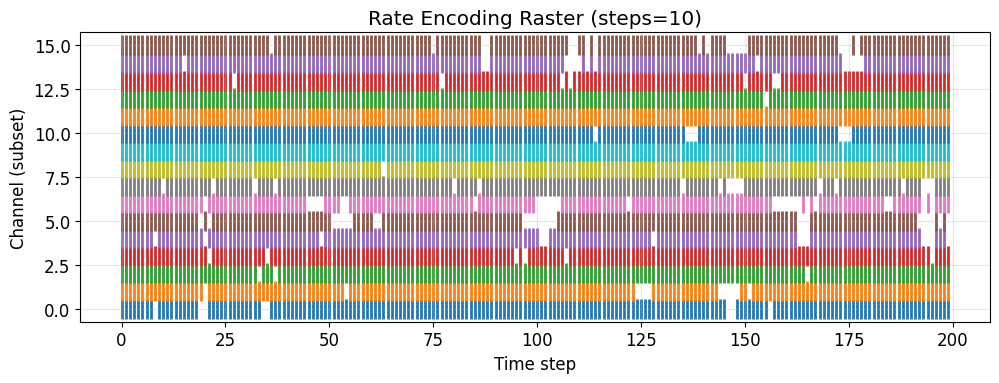

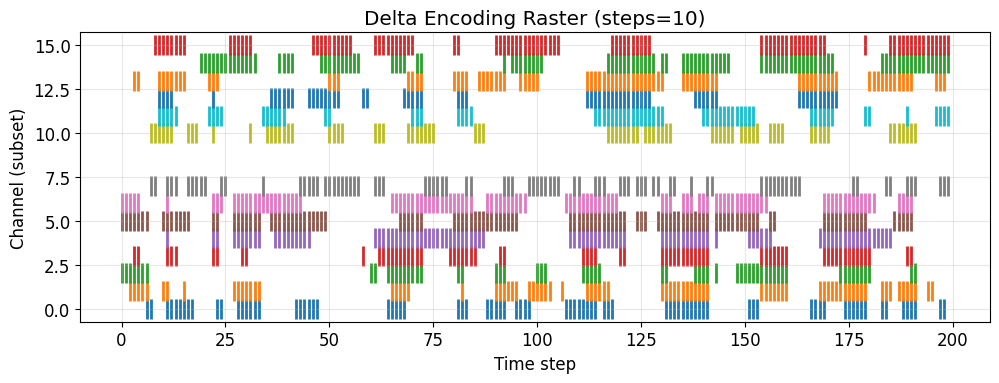

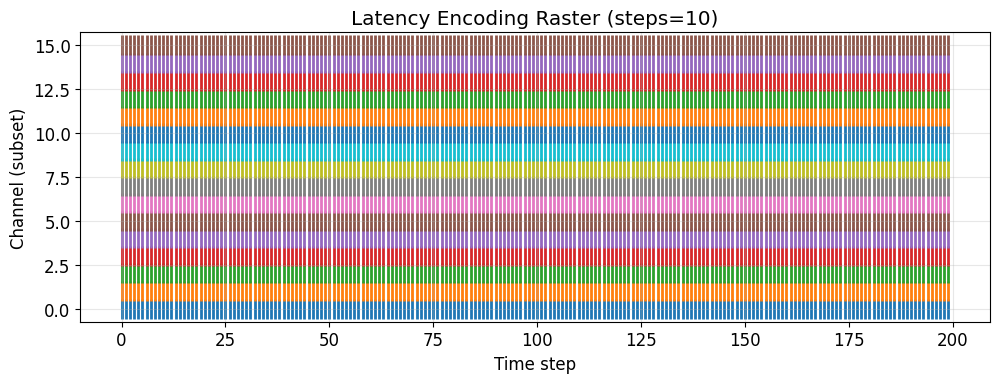

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# snnTorch imports
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import snntorch.spikegen as spikegen
import os
from torch.nn.utils.parametrizations import weight_norm
# ======================
# Dataset Class
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class EMGDataset(Dataset):
    """EMG 데이터셋 클래스"""
    def __init__(self, X, y, transform=None):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample, label

# ======================
# TCN Components
# ======================

class TemporalBlock(nn.Module):
    """TCN의 기본 빌딩 블록"""
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(n_outputs)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(n_outputs)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        # Residual connection
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)

        if out.shape != residual.shape:
            min_len = min(out.shape[2], residual.shape[2])
            out = out[:, :, :min_len]
            residual = residual[:, :, :min_len] 
            
        out += residual
        return self.relu(out)

class TemporalConvNet(nn.Module):
    """Temporal Convolutional Network"""
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            
            # Causal padding
            padding = (kernel_size - 1) * dilation_size
            
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, 
                                   stride=1, dilation=dilation_size, 
                                   padding=padding, dropout=dropout)]
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, features) -> (batch_size, features, seq_len)
        x = x.transpose(1, 2)
        out = self.network(x)
        # Back to (batch_size, seq_len, features)
        return out.transpose(1, 2)

# ======================
# SNN Components using snnTorch
# ======================

class SpikeEncoder(nn.Module):
    """연속 신호를 스파이크로 변환하는 인코더"""
    def __init__(self, encoding_type='rate', num_steps=10, 
                 latency_linear=False, latency_threshold=0.75, 
                 per_channel_norm=True):
        super(SpikeEncoder, self).__init__()
        self.encoding_type = encoding_type
        self.num_steps = num_steps
        self.latency_linear = latency_linear
        self.latency_threshold = latency_threshold
        self.per_channel_norm = per_channel_norm
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, features)
        batch_size, seq_len, features = x.shape
        if self.encoding_type == 'delta':
            spikes = spikegen.delta(x, threshold=0.2)   # (B, T_seq, C)

            # (B, T_seq, C) -> (1, B, T_seq, C)
            spikes = spikes.unsqueeze(0)  

            # T_sim만큼 복제: (T_sim, B, T_seq, C)
            spikes = spikes.repeat(self.num_steps, 1, 1, 1)

            return spikes
        if self.encoding_type == 'rate':
            # Rate encoding: 입력 크기에 비례하는 스파이크 확률
            # 입력을 0-1 범위로 정규화
            p = torch.sigmoid(x)  # (B,T,C)
                                            
            spikes = spikegen.rate(p, num_steps=self.num_steps)   # (num_steps, B, T, C)
            return spikes
        
        elif self.encoding_type == 'latency':
            if self.latency_threshold > 0:
                x = torch.where(x < self.latency_threshold, torch.zeros_like(x), x)

            # --- Normalization ---
            if self.per_channel_norm:
                # 채널별 min-max 정규화
                x_min = x.min(dim=1, keepdim=True)[0]  # (B,1,C)
                x_max = x.max(dim=1, keepdim=True)[0]  # (B,1,C)
                batch_norm = (x - x_min) / (x_max - x_min + 1e-8)
            else:
                # 배치 전체 min-max
                batch_norm = (x - x.min()) / (x.max() - x.min() + 1e-8)

            # --- Latency Encoding ---
            spikes = spikegen.latency(batch_norm, 
                                      num_steps=self.num_steps, 
                                      normalize=True, 
                                      linear=self.latency_linear)
            return spikes  # (num_steps, B, T, C)
        
        else:  # 'delta'
            # Delta modulation
            spikes = spikegen.delta(x, threshold=0.1)   # (B,T,C)

            # 2) 시간 차원 첫 번째로: (T,B,C)
            spikes = spikes.transpose(0, 1).contiguous()

            return spikes  # (T, B, C)

class SNNBlock(nn.Module):
    """SNN 블록 (LIF 뉴런 사용)"""
    def __init__(self, input_size, hidden_size, num_steps=10, beta=0.9, threshold=1.0):
        super(SNNBlock, self).__init__()
        
        self.num_steps = num_steps
        self.hidden_size = hidden_size
        
        # Linear layer
        self.fc = nn.Linear(input_size, hidden_size)
        
        # LIF neuron
        self.lif = snn.Leaky(beta=beta, threshold=threshold, 
                            spike_grad=surrogate.fast_sigmoid())
        
    def forward(self, x):                    # x: (T,B,input_size)
        T, B, _ = x.shape                    # ❗ self.num_steps 대신 T 사용
        mem = self.lif.init_leaky()
        spk_rec, mem_rec = [], []
        for t in range(T):
            cur = self.fc(x[t])              # (B,H)
            spk, mem = self.lif(cur, mem)
            spk_rec.append(spk); mem_rec.append(mem)
        return torch.stack(spk_rec, 0), torch.stack(mem_rec, 0)

class SpikingNeuralNetwork(nn.Module):
    """Multi-layer SNN"""
    def __init__(self, input_size, hidden_sizes, num_steps=10, beta=0.9, threshold=1.0, encoding_type='rate'):
        super(SpikingNeuralNetwork, self).__init__()
        
        self.num_steps = num_steps
        self.layers = nn.ModuleList()
        
        # Input encoding
        self.encoder = SpikeEncoder(encoding_type=encoding_type, num_steps=num_steps)
        
        # SNN layers
        layer_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)):
            self.layers.append(
                SNNBlock(layer_sizes[i], layer_sizes[i+1], 
                        num_steps=num_steps, beta=beta, threshold=threshold)
            )
    
    def forward(self, x):
        B, T, F = x.shape
        # num_steps 고정 사용
        num_steps = self.num_steps

        spikes = self.encoder(x)  # (num_steps, B, T_seq, C)  # latency 기준
        spikes = spikes.mean(dim=2).contiguous()  # (num_steps, B, C)

        for layer in self.layers:
            spikes, _ = layer(spikes)  # (num_steps, B, H)
        return spikes




# ======================
# Model Architectures
# ======================
class Chomp1d(nn.Module):
    """
    Remove extra padding from the right side
    """
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous() if self.chomp_size > 0 else x

spike_grad = surrogate.fast_sigmoid(slope=25)

class SpikingTemporalBlock(nn.Module):
    """Spiking 버전 Temporal Block (막전위 유지)"""
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2,
                 beta=0.9, v_th=1.0):
        super().__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.lif1  = snn.Leaky(beta=beta, threshold=v_th, spike_grad=spike_grad, init_hidden=False)
        self.do1   = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.lif2  = snn.Leaky(beta=beta, threshold=v_th, spike_grad=spike_grad, init_hidden=False)
        self.do2   = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None

    def forward(self, x, mem1, mem2, return_spk=False):
        x1 = self.chomp1(self.conv1(x))
        spk1, mem1 = self.lif1(x1, mem1)
        x1 = self.do1(spk1)

        x2 = self.chomp2(self.conv2(x1))
        spk2, mem2 = self.lif2(x2, mem2)
        out = self.do2(spk2)

        res = x if self.downsample is None else self.downsample(x)
        y = out + res

        if return_spk:
            # spk2: (B, C, T_seq) — 마지막 LIF의 바이너리 스파이크
            return y, mem1, mem2, spk2
        else:
            return y, mem1, mem2



# ======================
# Spiking Temporal ConvNet
# ======================
class SpikingTCN(nn.Module):
    """에너지 효율적인 Spiking-TCN (막전위 유지)"""
    def __init__(self, num_inputs, num_channels, num_classes,
                 kernel_size=2, dropout=0.2, timesteps=10, beta=0.9, v_th=1.0):
        super().__init__()
        self.timesteps = timesteps
        self.encoder = SpikeEncoder(encoding_type='rate', num_steps=timesteps)

        self.blocks = nn.ModuleList()
        for i in range(len(num_channels)):
            dilation = 2 ** i
            in_c  = num_inputs if i == 0 else num_channels[i-1]
            out_c = num_channels[i]
            pad   = (kernel_size - 1) * dilation
            self.blocks.append(
                SpikingTemporalBlock(in_c, out_c, kernel_size, 1, dilation, pad,
                              dropout=dropout, beta=beta, v_th=v_th)
            )

        self.classifier = nn.Linear(num_channels[-1], num_classes)

    @torch.no_grad()
    def collect_spike_stats(self, spike_buffers, T_total):
        """타임스텝 동안 누적된 스파이크로 간단 통계 산출"""
        stats = {}
        for bidx, buf in spike_buffers.items():
            stats[f'block{bidx}_lif1_rate_per_ch'] = (buf['lif1_sum'] / T_total)  # (C,)
            stats[f'block{bidx}_lif2_rate_per_ch'] = (buf['lif2_sum'] / T_total)  # (C,)
            stats[f'block{bidx}_lif1_total'] = buf['lif1_sum'].sum().item()
            stats[f'block{bidx}_lif2_total'] = buf['lif2_sum'].sum().item()
        return stats

    def forward(self, x, return_spikes=False):
        spikes = self.encoder(x)  # (T, B, F_in)
        mem_states = [(blk.lif1.init_leaky(), blk.lif2.init_leaky()) for blk in self.blocks]

        logits_sum = 0.0
        spk_tbC_list = []  # 여기 모아 T×B×C_last 로 반환

        for t in range(self.timesteps):
            cur = spikes[t]                  # (B, T_seq, C_in)
            cur = cur.transpose(1, 2).contiguous()  # (B, C_in, T_seq)

            for i, blk in enumerate(self.blocks):
                last_block = (i == len(self.blocks) - 1) and return_spikes
                if last_block:
                    cur, m1, m2, spk2 = blk(cur, *mem_states[i], return_spk=True)  # spk2: (B,C_last,T_seq)
                else:
                    cur, m1, m2 = blk(cur, *mem_states[i])
                mem_states[i] = (m1, m2)

            # 분류용 풀링
            pooled = cur.mean(dim=2)
            logits_sum += self.classifier(pooled)

            # 비교용 스파이크 시퀀스: (T,B,C_last)
            if return_spikes:
                # 래스터/히스토그램 비교를 위해 conv 시간축을 이진 합성:
                # conv 시간축 중 "한 번이라도 쏘면 1" 로 축약  => (B, C_last)
                spk_frame = (spk2 > 0).amax(dim=2).float()
                spk_tbC_list.append(spk_frame)

        logits = logits_sum / self.timesteps

        if return_spikes:
            spk_tbC = torch.stack(spk_tbC_list, dim=0)  # (T, B, C_last)
            # 원래 통계들에 같이 넣어서 보낼 수도 있고,
            # 최소한 spk_tbC만 넘겨도 시각화는 동일 루틴 재사용 가능
            stats = {"spk_tbC": spk_tbC}
            return logits, stats

        return logits

class TCNClassifier(nn.Module):
    """TCN 기반 EMG 분류기"""
    def __init__(self, input_size, num_classes, tcn_channels=[64, 128, 256], 
                 kernel_size=3, dropout=0.2):
        super(TCNClassifier, self).__init__()
        
        self.tcn = TemporalConvNet(input_size, tcn_channels, kernel_size, dropout)
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(tcn_channels[-1], num_heads=8, batch_first=True)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(tcn_channels[-1], 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        # TCN feature extraction
        tcn_out = self.tcn(x)  # (batch_size, seq_len, features)
        
        # Self-attention
        attn_out, _ = self.attention(tcn_out, tcn_out, tcn_out)
        
        # Global average pooling
        pooled = torch.mean(attn_out, dim=1)  # (batch_size, features)
        
        # Classification
        output = self.classifier(pooled)
        return output

class SNNClassifier(nn.Module):
    """SNN 기반 EMG 분류기"""
    def __init__(self, input_size, num_classes, hidden_sizes=[256, 128, 64], 
                 num_steps=10, beta=0.9, threshold=1.0, encoding_type='rate'):
        super(SNNClassifier, self).__init__()
        
        self.num_steps = num_steps
        self.snn = SpikingNeuralNetwork(input_size, hidden_sizes, 
                                       num_steps, beta, threshold, encoding_type)
        
        # Output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)
        
    def forward(self, x):
        batch_size, seq_len, features = x.shape
        
        # Get spike outputs from SNN
        spikes = self.snn(x)  # (num_steps, batch_size, hidden_size)

        spike_rates = spikes.mean(dim=0) # (B, H)  <-- 시간축 평균

        output = self.output_layer(spike_rates)
        
        return output



# ======================
# Data Loading Functions
# ======================

def load_ninapro_data(file_path):
    """NinaPro 데이터를 로드하고 전처리하는 함수"""
    try:
        # .mat 파일 로드
        data = sio.loadmat(file_path)
        
        print("Available keys in the data:", list(data.keys()))
        
        # EMG 데이터 추출
        if 'emg' in data:
            emg_data = data['emg']
        elif 'data' in data:
            emg_data = data['data']
        else:
            data_keys = [k for k in data.keys() if not k.startswith('__')]
            emg_data = data[data_keys[0]]
        
        # 라벨 데이터 추출
        if 'stimulus' in data:
            labels = data['stimulus'].flatten()
        elif 'restimulus' in data:
            labels = data['restimulus'].flatten()
        elif 'glove' in data:
            labels = data['glove']
            if labels.ndim > 1:
                labels = labels[:, 0]
        else:
            label_keys = [k for k in data.keys() if 'stimulus' in k.lower() or 'label' in k.lower()]
            if label_keys:
                labels = data[label_keys[0]].flatten()
            else:
                data_keys = [k for k in data.keys() if not k.startswith('__')]
                labels = data[data_keys[1]].flatten() if len(data_keys) > 1 else np.zeros(emg_data.shape[0])
        
        print(f"EMG data shape: {emg_data.shape}")
        print(f"Labels shape: {labels.shape}")
        print(f"Unique labels: {np.unique(labels)}")
        
        return emg_data, labels
    
    except Exception as e:
        print(f"Error loading data: {e}")
        print("Generating sample data for demonstration...")
        
        # 샘플 데이터 생성
        n_samples = 10000
        n_channels = 12
        emg_data = np.random.randn(n_samples, n_channels) * 0.1
        
        # EMG 신호처럼 보이도록 시간적 상관관계 추가
        for i in range(n_channels):
            emg_data[:, i] += np.sin(np.linspace(0, 100*np.pi, n_samples) + i) * 0.05
            emg_data[:, i] += np.convolve(np.random.randn(n_samples), 
                                        np.ones(5)/5, mode='same') * 0.02
        
        labels = np.random.randint(0, 7, n_samples)  # 0-6 클래스
        return emg_data, labels

def preprocess_data_for_networks(emg_data, labels, window_size=200, overlap=100):
    """네트워크를 위한 EMG 데이터 전처리"""
    # 레이블이 0인 rest 구간 제거 (선택사항)
    non_zero_mask = labels != 0
    emg_data = emg_data[non_zero_mask]
    labels = labels[non_zero_mask]
    
    # 윈도우 기반 시퀀스 생성
    windowed_sequences = []
    windowed_labels = []
    
    step_size = window_size - overlap
    
    for i in range(0, len(emg_data) - window_size + 1, step_size):
        window = emg_data[i:i+window_size]
        window_label = labels[i:i+window_size]
        
        # 윈도우 내에서 가장 빈번한 라벨 사용
        unique_labels, counts = np.unique(window_label, return_counts=True)
        dominant_label = unique_labels[np.argmax(counts)]
        
        windowed_sequences.append(window)
        windowed_labels.append(dominant_label)
    
    return np.array(windowed_sequences), np.array(windowed_labels)

# ======================
# Training Functions
# ======================

def train_model(model, train_loader, val_loader, num_epochs=2, lr=0.001):
    """모델 훈련 함수"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_acc = 0.0
    patience_counter = 0
    patience = 20
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        train_acc = 100 * train_correct / train_total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        
        # Learning rate scheduling
        scheduler.step(val_acc)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), './output/rate/best_model_rate.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%')
    
    # Load best model
    model.load_state_dict(torch.load('./output/rate/best_model_rate.pth'))
    
    history = {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'val_loss': val_losses,
        'val_acc': val_accuracies
    }
    
    return model, history

def evaluate_model(model, test_loader):
    """모델 평가 함수"""
    model.eval()
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    test_acc = 100 * test_correct / test_total
    return test_acc, np.array(all_predictions), np.array(all_targets)

# ======================
# Visualization Functions
# ======================

def plot_training_history(histories, model_names):
    """훈련 과정 시각화"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for i, (history, name) in enumerate(zip(histories, model_names)):
        color = colors[i % len(colors)]
        
        # Training accuracy
        axes[0, 0].plot(history['train_acc'], label=f'{name}', 
                       color=color, linewidth=2)
        
        # Validation accuracy
        axes[0, 1].plot(history['val_acc'], label=f'{name}', 
                       color=color, linewidth=2)
        
        # Training loss
        axes[1, 0].plot(history['train_loss'], label=f'{name}', 
                       color=color, linewidth=2)
        
        # Validation loss
        axes[1, 1].plot(history['val_loss'], label=f'{name}', 
                       color=color, linewidth=2)
    
    axes[0, 0].set_title('Training Accuracy', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_title('Validation Accuracy', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_title('Training Loss', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_title('Validation Loss', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Model Training Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    count_path = os.path.join("./output/rate", "model_trainint_rate4.png")
    plt.savefig(count_path)
    plt.close(fig)

def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    """혼동 행렬 시각화"""
    cm = confusion_matrix(y_true, y_pred)
    
    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    count_path = os.path.join("./output/rate", "rasterplot_rate4.png")
    plt.savefig(count_path)
    plt.close(fig)

def visualize_snn_spikes_new(model, sample_data, num_steps=10, num_neurons=100):
    """SNN 스파이크 시각화"""
    # if not hasattr(model, 'snn'):
    #     print("Model doesn't have SNN component")
    #     return
    
    model.eval()
    with torch.no_grad():
        sample_data = sample_data.to(device)
        x = sample_data[:1]
        
        # 하이브리드: TCN→Encoder→SNNCore 경로로 스파이크 생성
        if hasattr(model, 'tcn') and hasattr(model, 'encoder'):
            tcn_out = model.tcn(x)                 # (1, T, F_tcn)
            spikes = model.encoder(tcn_out)        # (T, 1, F_tcn)
            spk = model.snn(spikes)                # (T, 1, H)
        else:
            # 구형 모델 호환
            spk = model.snn(x)                     # (T, 1, H)
        
        # spikes shape: (num_steps, 1, hidden_size)
        spike_data = spk.squeeze(1).cpu().numpy()  # (num_steps, hidden_size)
        
        arr = np.asarray(spike_data)
        if arr.ndim == 3:        # (B, T, N)
            firing_rates = arr.mean(axis=(0,1))   # -> (N,)
        elif arr.ndim == 2:      # (T, N)
            firing_rates = arr.mean(axis=0)       # -> (N,)
        else:
            raise ValueError(f"Unexpected spike_data shape: {arr.shape}")

        fig = plt.figure(figsize=(15, 8))
        
        # Raster plot
        for neuron_idx in range(min(num_neurons, spike_data.shape[1])):
            spike_times = np.where(spike_data[:, neuron_idx] > 0.5)[0]
            plt.scatter(spike_times, [neuron_idx] * len(spike_times), 
                       marker='|', s=250, alpha=0.9, linewidths=2, color='black')
        
        plt.xlabel('Time Steps')
        plt.ylabel('Neuron Index')
        plt.title('SNN Spike Raster Plot')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        count_path = os.path.join("./output/rate", "snn_rate_raster4.png")
        plt.savefig(count_path)
        plt.close(fig)
      
        
        # Firing rate histogram
        fig = plt.figure(figsize=(12, 5))
        plt.bar(range(len(firing_rates)), firing_rates, alpha=0.7)
        plt.xlabel('Neuron Index')
        plt.ylabel('Firing Rate')
        plt.title('Neuron Firing Rates')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        count_path = os.path.join("./output/rate", "neuron_firing_rate4.png")
        plt.savefig(count_path)
        plt.close(fig)
import snntorch.spikeplot as splt
def plot_model_comparison_results(results):
    """모델 성능 비교 결과 시각화"""
    model_names = list(results.keys())
    accuracies = [results[name]['test_acc'] for name in model_names]
    
    fig = plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, accuracies, alpha=0.7, 
                   color=['blue', 'red', 'green', 'orange'])
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.ylabel('Test Accuracy (%)')
    plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    count_path = os.path.join("./output/rate", "model_performance_com_rate4.png")
    plt.savefig(count_path)
    plt.close(fig)

def visualize_snn_spikes(model, x, title_prefix="Model"):
    model.eval()
    with torch.no_grad():
        # 공통: (T, B, N) 형태의 spike 시퀀스를 확보
        if isinstance(model, SpikingTCN):
            logits, stats = model(x, return_spikes=True)
            spk = stats["spk_tbC"]  # (T, B, C_last)
        elif isinstance(model, SNNClassifier):
            spk = model.snn(x)      # (T, B, H)
        else:
            raise TypeError("SpikingTCN 또는 SNNClassifier만 지원")

        T, B, N = spk.shape
        # 발화율/카운트
        counts_per_neuron = spk.sum(dim=(0,1))        # (N,)
        rate_per_neuron   = counts_per_neuron / T     # 배치 평균된 타임스텝당 발화율
        total_spikes      = counts_per_neuron.sum().item()

        print(f"=== {title_prefix} Spike Stats ===")
        print(f"T={T}, B={B}, N={N}")
        print(f"Total spikes: {total_spikes:.0f}")
        print(f"Mean firing rate per neuron: {rate_per_neuron.mean():.4f}")
        print(f"Max firing rate per neuron:  {rate_per_neuron.max():.4f}")

        os.makedirs("./output/rate", exist_ok=True)

        # 히스토그램 (두 모델 동일)
        fig = plt.figure()
        plt.hist(rate_per_neuron.cpu().numpy(), bins=40)
        plt.title(f"{title_prefix} Neuron Firing Rate Distribution")
        plt.xlabel("Firing rate (spikes / timestep)")
        plt.ylabel("Neuron count")
        plt.savefig(os.path.join("./output/rate", f"{title_prefix}_rate_hist.png"))
        plt.close(fig)

        # 래스터 (두 모델 동일)
        fig = plt.figure(figsize=(10, 5))
        spk_cpu = spk.cpu()
        max_neurons = min(N, 100)
        for h in range(max_neurons):
            # (T, B)에서 nonzero: [t, b]
            nz = (spk_cpu[:, :, h] > 0).nonzero(as_tuple=False)
            if nz.numel() == 0:
                continue
            # 배치 인덱스를 살짝 오프셋으로 그려 겹침 방지
            plt.scatter(nz[:,0], h + nz[:,1]*0.1, 
                marker='|', s=250, alpha=0.9, linewidths=2, color='black')
        plt.title(f"{title_prefix} Raster (first {max_neurons} neurons)")
        plt.xlabel("Time step")
        plt.ylabel("Neuron index")
        plt.savefig(os.path.join("./output/rate", f"{title_prefix}_raster.png"))
        plt.close(fig)
        
DATA_PATH = "../../data/DB6/DB6_s1_a/S1_D1_T1.mat"
encoding_type = 'rate'
print("=== EMG Classification with TCN and SNN using PyTorch ===")
num_steps = 10
# 1. 데이터 로드
print("\n1. Loading data...")
emg_data, labels = load_ninapro_data(DATA_PATH)

# 2. 데이터 전처리
print("\n2. Preprocessing data...")
X, y = preprocess_data_for_networks(emg_data, labels, window_size=200, overlap=100)

print(f"Sequence data shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of classes: {len(np.unique(y))}")

# 3. 라벨 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))
class_names = [f"Gesture {i}" for i in range(num_classes)]

# 4. 데이터 분할
print("\n3. Splitting data...")
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# 5. 데이터 정규화
print("\n4. Normalizing data...")
scaler = StandardScaler()
# 2D로 변형 후 스케일링, 다시 3D로 복원
X_train_res = X_train.reshape(-1, X_train.shape[-1])
X_val_res = X_val.reshape(-1, X_val.shape[-1])
X_test_res = X_test.reshape(-1, X_test.shape[-1])
X_train_scaled = scaler.fit_transform(X_train_res).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val_res).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test_res).reshape(X_test.shape)
# 6. DataLoader 생성
print("\n5. Creating DataLoaders...")
train_dataset = EMGDataset(X_train_scaled, y_train)
val_dataset = EMGDataset(X_val_scaled, y_val)
test_dataset = EMGDataset(X_test_scaled, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_steps = 10
sample_input = torch.FloatTensor(X_test_scaled[:1])
encoder_rate = SpikeEncoder(encoding_type='rate', num_steps=num_steps)
encoder_delta = SpikeEncoder(encoding_type='delta', num_steps=num_steps)
encoder_latency = SpikeEncoder(encoding_type='latency', num_steps=num_steps)

# ============================
# 인코딩 실행
# ============================
print(sample_input.shape)
spikes_rate = encoder_rate(sample_input)       # shape: (num_steps, B, T, C)
spikes_delta = encoder_delta(sample_input)     # shape: (T, B, C)
spikes_latency = encoder_latency(sample_input) # shape: (T, B, C)

print("Rate encoding:", spikes_rate.shape)
print("Delta encoding:", spikes_delta.shape)
print("Latency encoding:", spikes_latency.shape)


# 래스터 (두 모델 동일)
def plot_raster(spikes_tc: np.ndarray, title: str, max_channels: int = 64):
    """
    spikes_tc: shape (T, C) in {0,1}
    """
    T, C = spikes_tc.shape
    C_plot = min(C, max_channels)
    plt.figure(figsize=(10, 4))
    for ch in range(C_plot):
        t_idx = np.where(spikes_tc[:, ch] > 0.5)[0]
        if t_idx.size > 0:
            # 세로 막대 느낌의 스파이크 마커
            plt.scatter(t_idx, np.full_like(t_idx, ch), marker='|', s=200, linewidths=2)
    plt.title(title)
    plt.xlabel("Time step")
    plt.ylabel("Channel (subset)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
spikes_rate_bc = (spikes_rate > 0.1).any(dim=0).float()   # step 차원 OR
# -> torch.Size([1, 200, 16])

# 배치 차원 제거 -> (T, C)
spikes_rate_tc = spikes_rate_bc.squeeze(0)

spikes_delta_bc = (spikes_delta > 0.1).any(dim=0).float()   # step 차원 OR
# -> torch.Size([1, 200, 16])

# 배치 차원 제거 -> (T, C)
spikes_delta_bc = spikes_delta_bc.squeeze(0)

spikes_latency_bc = (spikes_latency > 0.1).any(dim=0).float()   # step 차원 OR
# -> torch.Size([1, 200, 16])

# 배치 차원 제거 -> (T, C)
spikes_latency_bc = spikes_latency_bc.squeeze(0)

plot_raster(spikes_rate_tc,    f"Rate Encoding Raster (steps={num_steps})", max_channels=64)
plot_raster(spikes_delta_bc,   f"Delta Encoding Raster (steps={num_steps})", max_channels=64)
plot_raster(spikes_latency_bc, f"Latency Encoding Raster (steps={num_steps})", max_channels=64)


In [110]:
# pip install ptflops
import torch
from ptflops import get_model_complexity_info
class HybridTCNSNN(nn.Module):
    """TCN과 SNN을 결합한 하이브리드 모델"""
    def __init__(self, input_size, num_classes, tcn_channels=[64, 128, 256], 
                 snn_hidden_sizes=[64, 128, 256], num_steps=10, kernel_size=3, dropout=0.2, encoding_type='rate', beta=0.9, threshold=1.0):
        super(HybridTCNSNN, self).__init__()
        
        self.num_steps = num_steps
        
        # TCN branch
        self.tcn = TemporalConvNet(input_size, tcn_channels, kernel_size, dropout)
        
        # SNN branch
        self.snn = SpikingNeuralNetwork(input_size, snn_hidden_sizes, num_steps=num_steps, beta=beta, encoding_type=encoding_type, threshold=threshold)
        
        # Feature fusion
        combined_size = tcn_channels[-1] + snn_hidden_sizes[-1]
        self.fusion = nn.Sequential(
            nn.Linear(combined_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        # TCN branch
        tcn_out = self.tcn(x)
        # print(tcn_out.shape)
        tcn_pooled = tcn_out.mean(dim=1)  # Global average pooling
       
        # SNN branch
        snn_spikes = self.snn(x)
        # print(snn_spikes.shape)
        snn_rates = snn_spikes.mean(dim=0)   
        
        # Combine features
        combined = torch.cat([tcn_pooled, snn_rates], dim=1)
        
        # Final classification
        output = self.fusion(combined)
        return output
        
# --- 1) .pth 불러오기 (예시) ---
# from your_model_def import HybridTCNSNN  # 네가 정의한 클래스 임포트
model = HybridTCNSNN(input_size=X_train.shape[-1], num_classes=num_classes, encoding_type='rate', num_steps=20, beta=0.95, threshold=0.48)
state = torch.load("best_Hybrid_rate.pth", map_location="cpu")
model.load_state_dict(state)

# --- 2) THOP/PTFLOPS는 입력 shape이 (C, T) or (B,C,T) 중 채널-먼저를 예상 ---
# 너 모델이 (B,T,C)을 받는다면, 내부에서 transpose 하거나 wrapper로 바꿔줘야 해.
class ChannelFirstWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):      # x: (B, T, C)
        # ptflops는 (B, C, T) 포맷을 더 잘 처리 → 여기서는 모델이 (B,T,C)라면 그대로 사용
        return self.model(x)

# model = ChannelFirstWrapper(model)
model.eval()

# --- 3) TCN+Fusion만 카운트하고 싶으면 SNN 브랜치를 끄는 플래그/더미를 모델에 넣거나,
#       혹은 별도 TCN+Fusion-only 모델로 똑같이 불러서 측정하는 걸 권장 ---
# 아래는 전체 모델 FLOPs 예시 (SNN 연산은 제대로 카운트 안 됨)
with torch.no_grad():
    macs, params = get_model_complexity_info(
        model, (200, C),  # (T, C) → 내부에서 B 차원은 ptflops가 붙임
        as_strings=False, print_per_layer_stat=False, verbose=False
    )
# ptflops 'macs'는 MAC 수, FLOPs ~ 2*MAC으로 부르기도 하지만 논문별 정의 다름 → 일관되게 MAC으로 보고하면 안전
print("MACs (approx):", macs, " Params:", params)


Flops estimation was not finished successfully because of the following exception: 
<class 'RuntimeError'>: Expected p_in >= 0 && p_in <= 1 to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)
MACs (approx): None  Params: None


Traceback (most recent call last):
  File "/opt/miniconda3/envs/py312/lib/python3.12/site-packages/ptflops/pytorch_engine.py", line 68, in get_flops_pytorch
    _ = flops_model(batch)
        ^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/py312/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/py312/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1582, in _call_impl
    result = forward_call(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/zn/kw45qbbs5tl6x_yjvwylnzf80000gn/T/ipykernel_47872/3902395443.py", line 38, in forward
    snn_spikes = self.snn(x)
                 ^^^^^^^^^^^
  File "/opt/miniconda3/envs/py312/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^

In [111]:
# 1) 하이브리드 모델에서 SNN 브랜치를 우회하는 래퍼
class TCNFusionOnly(torch.nn.Module):
    def __init__(self, hybrid):
        super().__init__()
        self.tcn = hybrid.tcn
        self.fusion = hybrid.fusion
        self.c_tcn = hybrid.tcn.tcn_channels[-1] if hasattr(hybrid.tcn, 'tcn_channels') else None

    def forward(self, x):                # x: (B, T, C)
        tcn_out = self.tcn(x)            # (B, T, C_tcn_last) or (B, C_tcn_last, T) → 네 구현에 맞게
        tcn_pooled = tcn_out.mean(dim=1) # GAP over time (네 코드와 동일)
        # SNN branch는 0벡터로 대체
        B = tcn_pooled.size(0)
        snn_stub = tcn_pooled.new_zeros(B, self.fusion[0].in_features - tcn_pooled.size(1))
        combined = torch.cat([tcn_pooled, snn_stub], dim=1)
        return self.fusion(combined)

# 2) FLOPs 측정 (ptflops or thop)
from ptflops import get_model_complexity_info
m = TCNFusionOnly(model).eval()
macs, params = get_model_complexity_info(
    m, (200, C), as_strings=False, print_per_layer_stat=False, verbose=False
)
print("MACs:", macs, "Params:", params)


MACs: 90955911 Params: 503751


In [120]:
import torch
from ptflops import get_model_complexity_info

class SpikeEncoder(nn.Module):
    """연속 신호를 스파이크로 변환하는 인코더"""
    def __init__(self, encoding_type='rate', num_steps=10):
        super(SpikeEncoder, self).__init__()
        self.encoding_type = encoding_type
        self.num_steps = num_steps
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, features)
        batch_size, seq_len, features = x.shape
        if self.encoding_type == 'delta':
            # 1) (B,T,C) 그대로 delta에 투입
            #    snntorch.spikegen.delta는 (B,T,C) -> (B,T,C) 형태 반환(버전에 따라 다를 수 있으니 아래 체크 권장)
            spikes = spikegen.delta(x, threshold=0.1)   # (B,T,C)

            # 2) 시간 차원 첫 번째로: (T,B,C)
            spikes = spikes.transpose(0, 1).contiguous()

            return spikes  # (T, B, C)
        if self.encoding_type == 'rate':
            # Rate encoding: 입력 크기에 비례하는 스파이크 확률
            # 입력을 0-1 범위로 정규화
            p = torch.sigmoid(x)  # (B,T,C)
                                            
            spikes = spikegen.rate(p, num_steps=self.num_steps)   # (num_steps, B, T, C)
            return spikes
        
        elif self.encoding_type == 'latency':
            # Latency encoding
            spikes = spikegen.latency(x, num_steps=seq_len, normalize=True, linear=True)
            return spikes
        
        else:  # 'delta'
            # Delta modulation
            spikes = spikegen.delta(x, threshold=0.1)   # (B,T,C)

            # 2) 시간 차원 첫 번째로: (T,B,C)
            spikes = spikes.transpose(0, 1).contiguous()

            return spikes  # (T, B, C)
            
class SpikingTCN(nn.Module):
    """에너지 효율적인 Spiking-TCN (막전위 유지)"""
    def __init__(self, num_inputs, num_channels, num_classes,
                 kernel_size=2, dropout=0.2, timesteps=10, beta=0.9, v_th=1.0):
        super().__init__()
        self.timesteps = timesteps
        self.encoder = SpikeEncoder(encoding_type='rate', num_steps=timesteps)
        self.disable_encoder_for_flops = False

        self.blocks = nn.ModuleList()
        for i in range(len(num_channels)):
            dilation = 2 ** i
            in_c  = num_inputs if i == 0 else num_channels[i-1]
            out_c = num_channels[i]
            pad   = (kernel_size - 1) * dilation
            self.blocks.append(
                SpikingTemporalBlock(in_c, out_c, kernel_size, 1, dilation, pad,
                              dropout=dropout, beta=beta, v_th=v_th)
            )

        self.classifier = nn.Sequential(
            nn.Linear(num_channels[-1], 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Linear(64, num_classes)
        )

    @torch.no_grad()
    def collect_spike_stats(self, spike_buffers, T_total):
        """타임스텝 동안 누적된 스파이크로 간단 통계 산출"""
        stats = {}
        for bidx, buf in spike_buffers.items():
            stats[f'block{bidx}_lif1_rate_per_ch'] = (buf['lif1_sum'] / T_total)  # (C,)
            stats[f'block{bidx}_lif2_rate_per_ch'] = (buf['lif2_sum'] / T_total)  # (C,)
            stats[f'block{bidx}_lif1_total'] = buf['lif1_sum'].sum().item()
            stats[f'block{bidx}_lif2_total'] = buf['lif2_sum'].sum().item()
        return stats

    def forward(self, x, return_spikes=False):
        if self.disable_encoder_for_flops:
            spikes = x.new_zeros(self.timesteps, x.size(0), x.size(1), x.size(2))
        else:
            spikes = self.encoder(x)  # (T, B, F_in)
        
        mem_states = [(blk.lif1.init_leaky(), blk.lif2.init_leaky()) for blk in self.blocks]

        logits_sum = 0.0
        spk_tbC_list = []  # 여기 모아 T×B×C_last 로 반환

        for t in range(self.timesteps):
            cur = spikes[t]                  # (B, T_seq, C_in)
            cur = cur.transpose(1, 2).contiguous()  # (B, C_in, T_seq)

            for i, blk in enumerate(self.blocks):
                last_block = (i == len(self.blocks) - 1) and return_spikes
                if last_block:
                    cur, m1, m2, spk2 = blk(cur, *mem_states[i], return_spk=True)  # spk2: (B,C_last,T_seq)
                else:
                    cur, m1, m2 = blk(cur, *mem_states[i])
                mem_states[i] = (m1, m2)

            # 분류용 풀링
            pooled = cur.mean(dim=2)
            logits_sum += self.classifier(pooled)

            # 비교용 스파이크 시퀀스: (T,B,C_last)
            if return_spikes:
                # 래스터/히스토그램 비교를 위해 conv 시간축을 이진 합성:
                # conv 시간축 중 "한 번이라도 쏘면 1" 로 축약  => (B, C_last)
                spk_frame = (spk2 > 0).float().mean(dim=2) 
                spk_tbC_list.append(spk_frame)

        logits = logits_sum / self.timesteps

        if return_spikes:
            spk_tbC = torch.stack(spk_tbC_list, dim=0)  # (T, B, C_last)
            # 원래 통계들에 같이 넣어서 보낼 수도 있고,
            # 최소한 spk_tbC만 넘겨도 시각화는 동일 루틴 재사용 가능
            stats = {"spk_tbC": spk_tbC}
            return logits, stats

        return logits
# pth 로드
model.disable_encoder_for_flops = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpikingTCN(
        num_inputs=X_train.shape[-1],   # 채널 수(=특징 수)
        num_channels=[64, 128, 256],    # 기존 TCN 채널 구성 그대로
        num_classes=num_classes,
        kernel_size=3,
        dropout=0.2,
        timesteps=20,   # 6~16 권장 (낮출수록 지연/연산↓)
        beta=0.9,      # EMG는 0.9~0.99가 전이 유지에 유리
        v_th=1.25
    ).to(device)

# 저장된 .pth 가중치 로드
model.load_state_dict(torch.load("best_SpikingTCN_rate.pth", map_location=device))
model.eval()

class DummyEncoder(nn.Module):
    def __init__(self, Ts=1): 
        super().__init__(); self.Ts=Ts
    def forward(self, x):         # x: (B,T,C)
        B,T,C = x.shape
        return x.new_zeros(self.Ts, B, T, C)  # 전부 0 스파이크

orig_enc = model.encoder
model.encoder = DummyEncoder(Ts=model.timesteps)

from ptflops import get_model_complexity_info
model.eval()
macs, params = get_model_complexity_info(
    model, (1, 200, X_train.shape[-1]),  # (B,T,C) 형태를 받도록 forward가 구현돼 있으면 이대로
    as_strings=False, print_per_layer_stat=False, verbose=False
)
print(f"MACs: {macs:,} Params: {params:,}")

model.encoder = orig_enc  # 복구



Flops estimation was not finished successfully because of the following exception: 
<class 'ValueError'>: too many values to unpack (expected 3)


Traceback (most recent call last):
  File "/opt/miniconda3/envs/py312/lib/python3.12/site-packages/ptflops/pytorch_engine.py", line 68, in get_flops_pytorch
    _ = flops_model(batch)
        ^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/py312/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/py312/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1582, in _call_impl
    result = forward_call(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/zn/kw45qbbs5tl6x_yjvwylnzf80000gn/T/ipykernel_47872/4030332016.py", line 91, in forward
    spikes = self.encoder(x)  # (T, B, F_in)
             ^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/py312/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^

TypeError: unsupported format string passed to NoneType.__format__

In [122]:
import torch
import torch.nn as nn
from ptflops import get_model_complexity_info

# 1) Encoder를 우회하기 위한 더미 (FLOPs 측정 시 SNN 경로 비활성화)
class DummyEncoder(nn.Module):
    def __init__(self, Ts=1):
        super().__init__()
        self.Ts = Ts
    def forward(self, x_btc):         # 기대: (B,T,C)
        B, T, C = x_btc.shape
        # 스파이크 제로 텐서 반환하여 SNN 경로가 안전하게 통과되도록
        return x_btc.new_zeros(self.Ts, B, T, C)

# 2) ptflops 입력(B, C, T) → 모델 입력(B, T, C)로 변환해주는 래퍼
class FlopsWrapper(nn.Module):
    def __init__(self, spiking_tcn):
        super().__init__()
        self.m = spiking_tcn
    def forward(self, x_bct):          # ptflops가 넣는 형태: (B, C, T)
        # (B,C,T) → (B,T,C)로 변환
        x_btc = x_bct.transpose(1, 2).contiguous()
        # FLOPs 측정 시에는 return_spikes=False 로 호출
        return self.m(x_btc, return_spikes=False)

# --- 실제 사용 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 0) 모델 생성 + 가중치 로드 (classifier 구조 일치 필수)
model = SpikingTCN(
        num_inputs=X_train.shape[-1],   # 채널 수(=특징 수)
        num_channels=[64, 128, 256],    # 기존 TCN 채널 구성 그대로
        num_classes=num_classes,
        kernel_size=3,
        dropout=0.2,
        timesteps=20,   # 6~16 권장 (낮출수록 지연/연산↓)
        beta=0.9,      # EMG는 0.9~0.99가 전이 유지에 유리
        v_th=1.25
    ).to(device)

state = torch.load("best_SpikingTCN_rate.pth", map_location=device)
missing = model.load_state_dict(state, strict=False)  # 필요 시 classifier 키만 무시
print("load_state_dict:", missing)

# 1) Encoder 더미로 교체 (FLOPs 측정시에만)
orig_encoder = model.encoder
model.encoder = DummyEncoder(Ts=model.timesteps)

# 2) (B,C,T) → (B,T,C) 변환 래퍼로 감싸기
wrapped = FlopsWrapper(model).to(device).eval()

# 3) ptflops 호출
#    input_res는 "배치 제외한 텐서 크기"이며, 1D conv 기준 (C, T) 순서가 안정적
C = X_train.shape[-1]
T = 200
with torch.no_grad():
    macs, params = get_model_complexity_info(
        wrapped,
        (C, T),                    # (C, T) !!  (B는 내부에서 1로 붙음)
        as_strings=False,
        print_per_layer_stat=False,
        verbose=False
    )

print(f"MACs: {macs:,}  Params: {params:,}")

# 4) Encoder 원복
model.encoder = orig_encoder



load_state_dict: <All keys matched successfully>
MACs: 170,572,940  Params: 470,087


In [130]:
# We'll create a Python script and a sample CSV to help the user compute the
# accuracy–energy trade-off using their .pth models and spike statistics.
#
# The script will:
# 1) Load user models from .pth (requires the user to provide a builder function).
# 2) Estimate dense MACs (Conv1d / Linear / LSTM) without external deps (ptflops optional).
# 3) Combine MACs + spikes + synaptic events into E_hat = α*MACs + β*spikes + γ*syn_events.
# 4) Plot Macro-F1 vs E_hat and save a CSV with the computed metrics.
#
# NOTE: This environment has no internet; we won't execute the FLOPs on unknown models.
# We just generate a ready-to-run script and a sample CSV.
import os, textwrap, pandas as pd

script_path = "./energy_tradeoff_tool.py"
script = r'''
#!/usr/bin/env python3
"""
Energy–Accuracy Trade-off Tool for sEMG Models

Usage (CLI examples):
  python energy_tradeoff_tool.py \
      --stats_csv spike_stats.csv \
      --alpha 1.0 --beta 0.01 --gamma 0.001 \
      --input_shape "1,200,8" \
      --model_builder "user_models:build_model" \
      --weights_map "LSTM:checkpoints/lstm.pth,TCN:checkpoints/tcn.pth,Hybrid:checkpoints/hybrid.pth,SpikingTCN:checkpoints/spikingtcn.pth,SNN:checkpoints/snn.pth" \
      --out_csv "tradeoff_results.csv" \
      --out_plot "tradeoff_plot.png"

What you need to provide:
- A CSV (spike_stats.csv) with columns:
    model_name,encoding,Ts,accuracy,macro_f1,total_spikes,mean_firing_rate,fan_in_avg(optional),syn_events(optional)
- A Python module with a function `build_model(model_name: str) -> torch.nn.Module`
  referenced as "module_path:function_name" in --model_builder. Example: "user_models:build_model".
- A map of model_name to .pth paths via --weights_map.

This script will:
- Load models and estimate dense MACs (Conv1d, Linear, LSTM) given an example input shape (B,T,C).
- If syn_events is not provided in CSV, approximate syn_events = total_spikes * fan_in_avg.
- Compute E_hat = alpha*MACs_dense + beta*total_spikes + gamma*syn_events
- Save a scatter plot of Macro-F1 vs E_hat and an output CSV.
"""

import argparse
import importlib
import math
import sys
from typing import Dict, Tuple

import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# Lightweight MACs Estimator
# ---------------------------
class MACsCounter:
    def __init__(self):
        self.macs = 0
        self.hooks = []

    def _conv1d_macs(self, module: nn.Conv1d, inp, out):
        # inp: tuple(tensor), out: tensor; shapes (B, Cin, Lin), (B, Cout, Lout)
        x = inp[0]
        B, Cin, Lin = x.shape
        Cout, _, K = module.weight.shape  # (Cout, Cin/groups, K)
        Lout = out.shape[-1]
        groups = module.groups if hasattr(module, "groups") else 1
        macs = B * Cout * Lout * (Cin // groups) * K
        self.macs += macs

    def _linear_macs(self, module: nn.Linear, inp, out):
        x = inp[0]
        # Support (B, *, in_features)
        in_features = module.in_features
        out_features = module.out_features
        # Flatten batch dims except last
        num_elements = x.numel() // in_features
        macs = num_elements * in_features * out_features
        self.macs += macs

    def _lstm_macs(self, module: nn.LSTM, inp, out):
        # Rough estimate for LSTM: per time step 4*(in*hid + hid*hid) per layer, times T and B
        # inp[0]: (seq_len, batch, input_size) or (batch, seq_len, input_size) if batch_first
        x = inp[0]
        batch_first = module.batch_first if hasattr(module, "batch_first") else False
        if batch_first:
            B, T, I = x.shape
        else:
            T, B, I = x.shape

        total = 0
        num_layers = module.num_layers
        H = module.hidden_size
        D = 2 if module.bidirectional else 1

        # For simplicity, approximate each layer
        in_size = I
        for layer in range(num_layers):
            # gates = 4*(in*H + H*H) per direction
            per_dir = 4 * (in_size * H + H * H)
            total_layer = D * per_dir * B * T
            total += total_layer
            in_size = H * D  # next layer input

        self.macs += total

    def add_hooks(self, model: nn.Module):
        def register(module):
            if isinstance(module, nn.Conv1d):
                h = module.register_forward_hook(self._conv1d_macs)
                self.hooks.append(h)
            elif isinstance(module, nn.Linear):
                h = module.register_forward_hook(self._linear_macs)
                self.hooks.append(h)
            elif isinstance(module, nn.LSTM):
                h = module.register_forward_hook(self._lstm_macs)
                self.hooks.append(h)

        model.apply(register)

    def remove_hooks(self):
        for h in self.hooks:
            h.remove()
        self.hooks = []

    def count(self, model: nn.Module, example_input: torch.Tensor) -> int:
        self.macs = 0
        self.add_hooks(model)
        with torch.no_grad():
            _ = model(example_input)
        self.remove_hooks()
        return int(self.macs)


def parse_shape(shape_str: str) -> Tuple[int, int, int]:
    parts = [int(x.strip()) for x in shape_str.split(",")]
    if len(parts) != 3:
        raise ValueError("input_shape must be 'B,T,C'")
    return parts[0], parts[1], parts[2]


def load_models_and_count_macs(builder_ref: str,
                               weights_map: Dict[str, str],
                               input_shape: Tuple[int, int, int]) -> Dict[str, int]:
    """
    builder_ref: "module_path:function_name" that returns nn.Module for a given model_name
    weights_map: {"LSTM":"path/to.pth", ...}
    input_shape: (B,T,C)
    """
    module_path, func_name = builder_ref.split(":")
    builder_module = importlib.import_module(module_path)
    builder_fn = getattr(builder_module, func_name)

    macs_counter = MACsCounter()
    macs_dict = {}

    B, T, C = input_shape
    example_input = torch.randn(B, T, C)

    for model_name, wpath in weights_map.items():
        model = builder_fn(model_name)
        # Load weights
        state = torch.load(wpath, map_location="cpu")
        # Support state dict inside a dict or straight state dict
        if isinstance(state, dict) and "state_dict" in state:
            state = state["state_dict"]
        try:
            model.load_state_dict(state, strict=False)
        except Exception as e:
            print(f"[WARN] load_state_dict failed for {model_name}: {e} (continuing without weights)")
        model.eval()

        macs = macs_counter.count(model, example_input)
        macs_dict[model_name] = macs
        print(f"[MACs] {model_name}: {macs:,} MACs (for input {input_shape})")

    return macs_dict


def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--stats_csv", required=True, help="CSV with spike stats + accuracy")
    ap.add_argument("--alpha", type=float, default=1.0)
    ap.add_argument("--beta", type=float, default=0.01)
    ap.add_argument("--gamma", type=float, default=0.001)
    ap.add_argument("--input_shape", default="1,200,8", help="B,T,C for MACs probe")
    ap.add_argument("--model_builder", required=False, help='e.g. "user_models:build_model"')
    ap.add_argument("--weights_map", required=False,
                    help='Comma list "Name:path,Name2:path2" to load .pth and count MACs')
    ap.add_argument("--out_csv", default="tradeoff_results.csv")
    ap.add_argument("--out_plot", default="tradeoff_plot.png")
    args = ap.parse_args()

    df = pd.read_csv(args.stats_csv)

    # Optional: load models and compute dense MACs
    macs_dict = {}
    if args.model_builder and args.weights_map:
        weights_map = {}
        for kv in args.weights_map.split(","):
            name, path = kv.split(":")
            weights_map[name.strip()] = path.strip()
        B, T, C = parse_shape(args.input_shape)
        macs_dict = load_models_and_count_macs(args.model_builder, weights_map, (B, T, C))

    # Attach MACs to rows by model_name (fallback 0 if not provided/loaded)
    df["dense_macs"] = df["model_name"].map(lambda n: macs_dict.get(n, 0))

    # Approximate synaptic events if not present
    if "syn_events" not in df.columns or df["syn_events"].isna().all():
        if "fan_in_avg" in df.columns:
            df["syn_events"] = df["total_spikes"] * df["fan_in_avg"]
        else:
            # conservative fallback: syn_events ~= total_spikes * 50
            df["syn_events"] = df["total_spikes"] * 50

    # Compute E_hat
    df["E_hat"] = args.alpha * df["dense_macs"] + args.beta * df["total_spikes"] + args.gamma * df["syn_events"]

    # Normalise E_hat for nicer plotting (min-max to [0,1], but keep raw too)
    Emin, Emax = df["E_hat"].min(), df["E_hat"].max()
    if Emax > Emin:
        df["E_hat_norm"] = (df["E_hat"] - Emin) / (Emax - Emin)
    else:
        df["E_hat_norm"] = 0.0

    # Save results
    df.to_csv(args.out_csv, index=False)
    print(f"[OK] Saved: {args.out_csv}")

    # Plot Macro-F1 vs E_hat (normalised)
    plt.figure()
    for name, g in df.groupby("model_name"):
        plt.scatter(g["E_hat_norm"], g["macro_f1"], label=name)
        # annotate points with (encoding, Ts)
        for _, row in g.iterrows():
            label = f'{row.get("encoding","")}, Ts={row.get("Ts","")}'
            plt.annotate(label, (row["E_hat_norm"], row["macro_f1"]),
                         textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)
    plt.xlabel("Estimated energy $\hat{E}$ (normalised)")
    plt.ylabel("Macro-F1 (%)")
    plt.title("Accuracy–Energy Trade-off")
    plt.legend()
    plt.tight_layout()
    plt.savefig(args.out_plot, dpi=200)
    print(f"[OK] Saved plot: {args.out_plot}")


if __name__ == "__main__":
    main()
'''

with open(script_path, "w") as f:
    f.write(script)

# Create a sample CSV template the user can edit/fill.
csv_path = "./sample_spike_stats.csv"
df = pd.DataFrame({
    "model_name": ["SNN","SNN","Hybrid","SpikingTCN", "SpikingTCN"],
    "encoding":   ["latency","latency","delta","rate", "latency"],
    "Ts":         [10,14,20,20,40],
    "accuracy":   [61.78, 62.84,87.78,76.61, 64.14],
    "macro_f1":   [61.55, 62.81,87.83,76.3, 64.28],
    "total_spikes":[396,673,60,3271, 945],
    "mean_firing_rate":[15.4,18.78,1.17,31.95, 18.46],
    "fan_in_avg":[128,128,128,128, 128],  # adjust if you know actual fan-in
    # "syn_events": []  # leave blank to auto-compute = total_spikes * fan_in_avg
})
df.to_csv(csv_path, index=False)

script_path, csv_path


('./energy_tradeoff_tool.py', './sample_spike_stats.csv')